# Autocodificadores 

Los autocodificadores (autoencoders) son redes que mapean una entrada a un espacio latente y lo devuelven al espacio de la entrada. La ventaja que proveen es que pueden representar una entrada como un conjunto de características (latentes); en muchas veces dichas características son menos que el espacio de entrada y por tanto podemos manipularlas de forma conceptual en lugar de su representación fenomenológica.

Un auto encoder se representa típicamente como:

$$
r = g(f(x))
$$

, donde $x$ es la entrada, $f$ una función codificadora (codificador), $g$ una función decodificadora (decodifricador) y $r$ la reconstrucción.



@SauloGante
@juan1rving


In [1]:
# Paquetes

import torch #para realizar operaciones con tensores es la libreria basica
import torchvision #Contiene paquetes para trabajar con datasets populares, arquitecturas e imagenes de vision computacional
import matplotlib.pyplot as plt 
from matplotlib.pyplot      import close, figure, imshow, savefig, show, title
from matplotlib.lines       import Line2D
from os.path                import join
import numpy as np


In [ ]:
# Verificar GPU

print("¿Esta el GPU disponible?:",torch.cuda.is_available())
device = torch.cuda.current_device()
print('Propiedades del dispositivo:',torch.cuda.get_device_properties(device))

¿Esta el GPU disponible?: True
Propiedades del dispositivo: _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 SUPER', major=7, minor=5, total_memory=7966MB, multi_processor_count=48)


## Datos

###### Importar datos

In [3]:
img_transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5],[0.5])
])

In [4]:
dataset=torchvision.datasets.MNIST(root='./data', train=True, transform=img_transform, download=True)
print('Tamaño del conjunto de datos',len(dataset))

Tamaño del conjunto de datos 60000


In [5]:
dataset_validacion =torchvision.datasets.MNIST(root='./data', train=False, transform=img_transform, download=True)
print('Tamaño del conjunto de datos de validación',len(dataset_validacion))

Tamaño del conjunto de datos de validación 10000


###### Preparar datos de entrenamiento 

In [58]:
dataloader=torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True)
dataloader_validacion = torch.utils.data.DataLoader(dataset_validacion, batch_size=10000, shuffle=True)

## Arquitectura

In [7]:
class autoencoder(torch.nn.Module):
    
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            
            torch.nn.Linear(28*28, 128), 
            torch.nn.ReLU(True),
            
            torch.nn.Linear(128,64),
            torch.nn.ReLU(True),
            
            torch.nn.Linear(64,12), 
            torch.nn.ReLU(True), 
            
            torch.nn.Linear(12,1))
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(1,12),
            torch.nn.ReLU(True),
            
            torch.nn.Linear(12,64),
            torch.nn.ReLU(True),
            
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(True), 
            
            torch.nn.Linear(128, 28*28), 
            torch.nn.Tanh())
        self.encode = True
        self.decode = True

    def forward(self, x):
        
        x = self.encoder(x)
        x =self.decoder(x)
        return x

## Entrenamiento 

In [8]:
model=autoencoder().cuda()

In [151]:
# Entrenamiento
# Entradas: Dataset, modelo, funciondeperdida, optimizador
# Salidas: Error
def entrena(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        img = X
        img = img.view(img.size(0), -1)
        img = torch.autograd.Variable(img).cuda() 

        #=============forward==================
        output = model(img)
        loss = loss_fn(output, img)

        #=============backward=================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #if batch % 20 == 0:
        #    loss, current = loss.item(), (batch + 1) * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

In [152]:
#Validación
# Entradas: Dataset, modelo, funciondeperdida
# Salidas: Error_promedio
def valida(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    loss = 0.0

    with torch.no_grad():
        for data in dataloader:
            img, _ = data
            img = img.view(img.size(0), -1)
            img = torch.autograd.Variable(img).cuda() 
            prediccion = model(img)
            test_loss = loss_fn(prediccion, img)
            loss += test_loss.item()
    
    loss /= num_batches
    #print("Error prueba: El error promedio es: {}".format(loss))
    return loss

In [154]:
num_epochs=2 #Numero de epocas
criterion=torch.nn.MSELoss() #Metrica error
optimizer=torch.optim.Adam(  #Optimizador
    model.parameters(), 
    lr=1e-5, 
    weight_decay=1e-5)

loss_ant = 10.0
losses = {"entrenamiento":[], "validación":[]}
for epoch in range(num_epochs):
    
    print(f"Época {epoch+1}\n-------------------------------")
    loss_entrena = entrena(dataloader, model, criterion, optimizer)
    loss_valida = valida(dataloader_validacion, model, criterion)
    #============saveb_weights==============
    losses["entrenamiento"].append(loss_entrena.item())
    losses["validación"].append(loss_valida)
    
    if loss_entrena.item() < loss_ant:
        torch.save(model.state_dict(), 'weights_entrenamiento_autoencMNISTprueba.pth')
        loss_ant = loss_entrena.item()
        mejor = epoch
        print("loss min: {}".format(loss_ant))

    #================log========================    
    if epoch % 10 == 0:
        loss_value=loss_entrena.cpu().detach().numpy()
        print("Numero de epoca:",epoch+1,'Funcion de perdida:',loss_value)

print('Final:\n')        
print("Numero de epoca:",epoch+1,'Funcion de perdida:',loss_entrena)
#winsound.Beep(440,1000)    

Época 1
-------------------------------
loss min: 0.8901017308235168
Numero de epoca: 1 Funcion de perdida: 0.89010173
Época 2
-------------------------------
loss min: 0.8472817540168762
Final:

Numero de epoca: 2 Funcion de perdida: tensor(0.8473, device='cuda:0', grad_fn=<MseLossBackward0>)


#### Ploteo de errores durante el entrenamiento

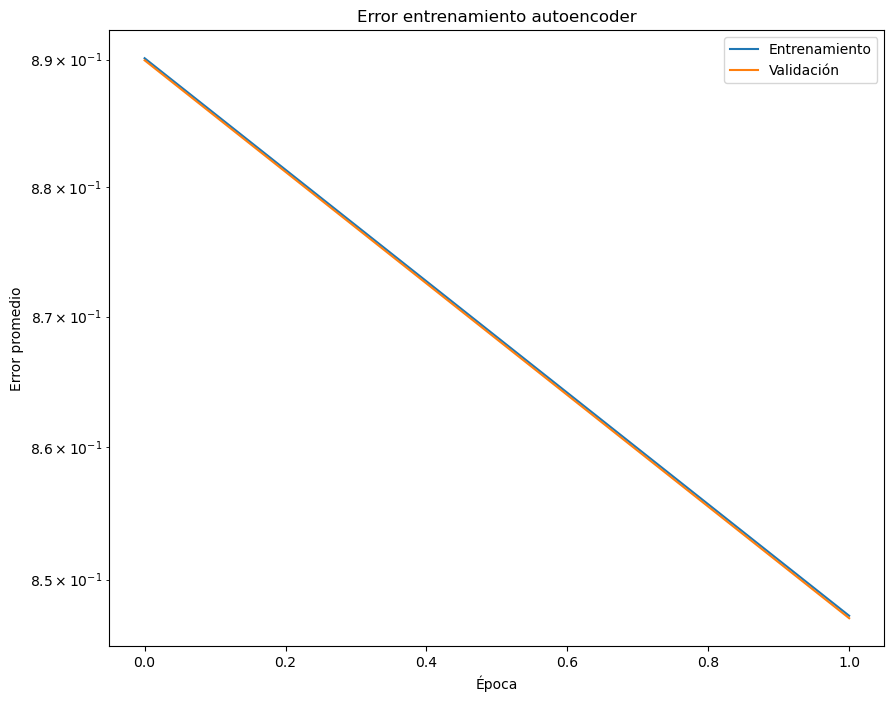

In [157]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(losses['entrenamiento'], label='Entrenamiento')
plt.semilogy(losses['validación'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Error promedio')
#plt.grid()
plt.legend()
plt.title('Error entrenamiento autoencoder')
plt.show()

In [48]:
torch.save({'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss}, 
        'MNIST_autoencoder.pth')

## Resultados 

In [9]:
##GPU
#model_test=autoencoder().cuda()

##CPU
model_test=autoencoder()
checkpoint_test=torch.load('weights_entrenamiento_autoencMNIST.pth')
model_test.load_state_dict(torch.load('weights_entrenamiento_autoencMNIST.pth'))
model_test.eval()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)

Text(0.5, 1.0, 'Salida Codificador')

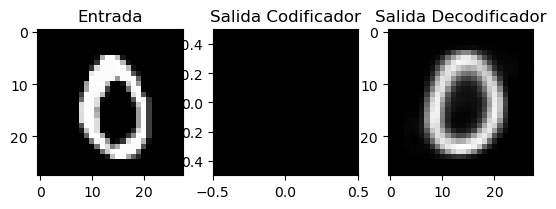

In [10]:
input_, _ = dataset[582] 
#procesamiento dato de entrada
input_test = input_.view(input_.size(0), -1)
output_test=model_test(input_test)
code_output=model_test.encoder(input_test)
#procesamiento dato de salida de autoencoder
output_test=output_test.reshape(28,28)
output_test=output_test.detach().numpy() 
#procesamiento de dato salida del codificador
img_code=code_output.reshape(1,-1)
img_code=img_code.detach().numpy()


#Visualización
plt.subplot(1, 3, 1)
plt.imshow(input_.numpy()[0],cmap='gray')
plt.title("Entrada")


plt.subplot(1, 3, 3)
plt.imshow(output_test,cmap='gray')
plt.title("Salida Decodificador")

plt.subplot(1, 3, 2)
plt.imshow(img_code,cmap='gray')
plt.title("Salida Codificador")

#### Generación de imagenes con el espacio latente

Generaremos nuevas imágenes utilizando el espacio latente, para ello del conjunto de datos de validación se calculará una distribución normal con la media y una desviación estandar de los datos condificados por el _encoder_. El resultado se ingresará al _decoder_, que será el encargado de reconstruir las imágenes según el valor ingresado.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


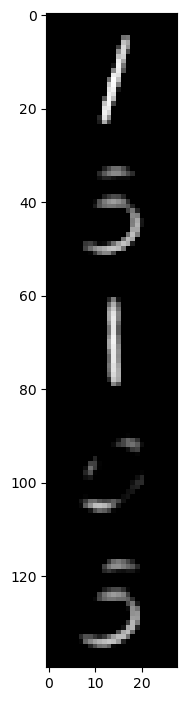

In [53]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

model.eval()

with torch.no_grad():
    
    # calcula la media y la desviación estándar del código latente, generado tomando imágenes de prueba como entradas 
    dataiter = iter(dataloader_validacion)
    images, labels = next(dataiter)
    images = images.view(images.size(0), -1)
    latent = model_test.encoder(images)
    latent = latent.cpu()
    mean = latent.mean(dim=0)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()

    # muestreo de vectores latentes de la distribución normal
    latent = torch.randn(512, 1)*std + mean

    # Reconstrucción con valores al azar del vector latente
    img_recon = model_test.decoder(latent)
    img_recon = img_recon.reshape(14336,28)
    img_recon = img_recon.cpu()
    
    # visualizacion de 5 valores resultantes
    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:140],10,5))
    plt.show()

## Graficos de espacio latente


In [59]:
datos = {"codificado":[], "etiqueta":[]}
dataiter = iter(dataloader_validacion)
images, labels = next(dataiter)
images = images.view(images.size(0), -1)
encoded_features = model_test.encoder(images)
for i in range (len(encoded_features)):

    datos['codificado'].append(encoded_features[i].item())
    datos['etiqueta'].append(labels[i])



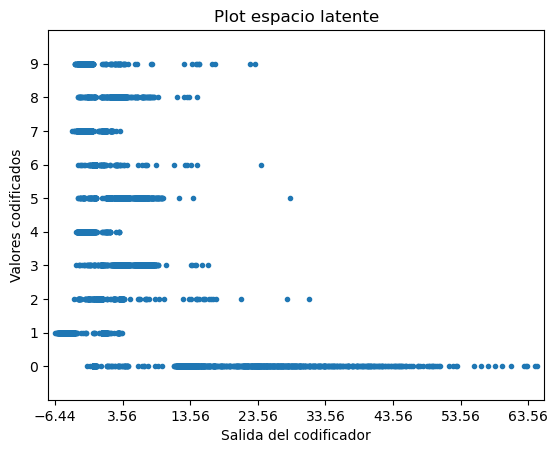

In [65]:
# plot
fig, ax = plt.subplots()

ax.scatter(datos["codificado"], datos["etiqueta"], marker = '.')

ax.set(xlabel='Salida del codificador', ylabel='Valores codificados', 
       xlim=(min (datos['codificado'])-1, max(datos['codificado'])+1), 
       xticks=np.arange(min (datos['codificado']), max(datos['codificado']), 10),
       ylim=(-1, 10), yticks=np.arange(0,10))

plt.title("Plot espacio latente")
plt.show()